<a href="https://colab.research.google.com/github/thekaitran/BA775-FallProject-KT/blob/main/M2_FILES/Kai_Tran_ProjectM2_Q1_BA820_Team_4_Childcare_Costs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Childcare Costs Dataset**


---



### Executive Summary

Childcare isn't just a family issue; it’s a major economic factor. In the U.S., childcare is often one of the biggest expenses for a household, sometimes costing between 8.9% and 16% of a family's income, in many places, that is more than rent!

Research shows that when prices go up, parents (especially mothers) are often forced to leave the workforce. This project looks beyond just "average prices" to understand the diverse childcare markets across the U.S. We want to understand how costs relate to income, employment, and local economies so policymakers and employers can make better decisions.

# **1. Data Sources**

We are using the National Database of Childcare Prices (NDCP), which covers U.S. county-level data from 2008–2018. The dataset includes:

Price Data: Weekly costs broken down by provider type (Center-based vs. Family-based) and age (Infant, Toddler, Preschool).

Socioeconomic Data: Census information including median income, poverty rates, unemployment, and labor force participation.

# **2. Data Import and Cleaning**

## 2.1 Python Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

!pip -q install umap-learn
import umap

Mounted at /content/drive


## 2.2 Importing Data

In [2]:
childcare = pd.read_csv("/content/drive/MyDrive/Boston University/Master/Spring26/BA820/childcare_costs.csv")
counties  = pd.read_csv("/content/drive/MyDrive/Boston University/Master/Spring26/BA820/counties.csv")

print("childcare shape:", childcare.shape)
print("counties shape:", counties.shape)

df = childcare.merge(counties, on="county_fips_code", how="left")

childcare shape: (34567, 61)
counties shape: (3144, 4)


## 2.3 Preliminary EDA

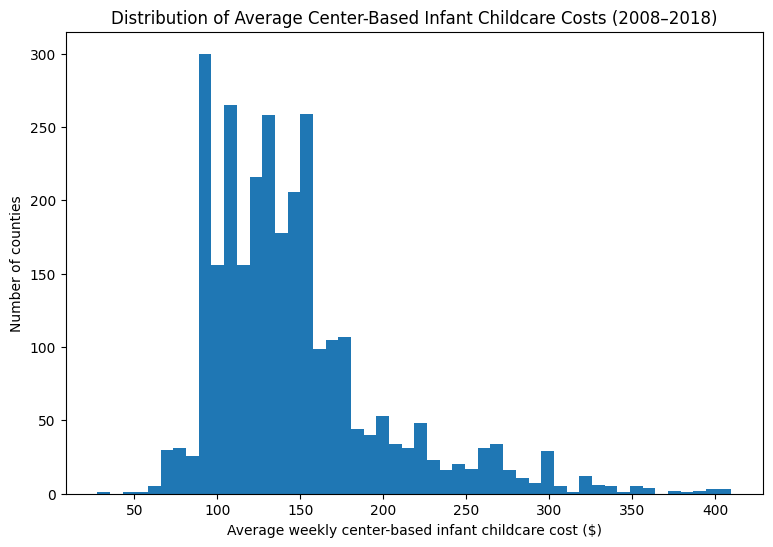

In [3]:
# Average each numeric variable across all years for each county
df_avg = (df.groupby("county_fips_code").mean(numeric_only=True).reset_index())
infant_prices_avg = df_avg["mc_infant"].dropna()
plt.figure(figsize=(9,6))
plt.hist(infant_prices_avg, bins=50)
plt.xlabel("Average weekly center-based infant childcare cost ($)")
plt.ylabel("Number of counties")
plt.title("Distribution of Average Center-Based Infant Childcare Costs (2008–2018)")

plt.show()


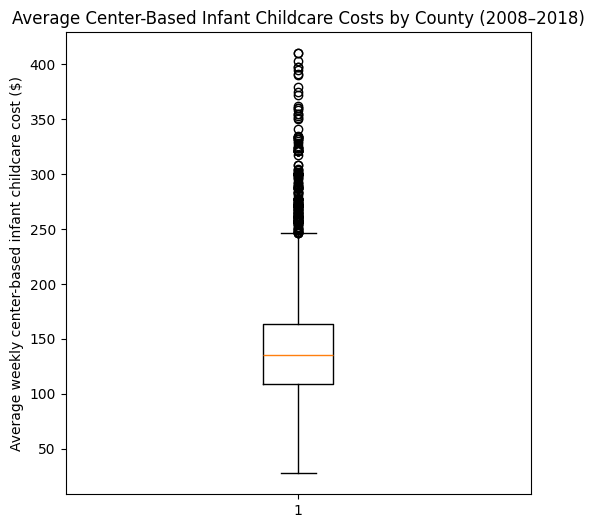

In [4]:
plt.figure(figsize=(6,6))
plt.boxplot(infant_prices_avg, vert=True, showfliers=True)
plt.ylabel("Average weekly center-based infant childcare cost ($)")
plt.title("Average Center-Based Infant Childcare Costs by County (2008–2018)")
plt.show()

The histogram and boxplot of county-level average center-based infant childcare costs (2008–2018) reveal substantial heterogeneity across U.S. counties. The distribution is strongly right-skewed, with most counties clustered between roughly $90 and $160 per week, and a long upper tail extending beyond $350–$400. This indicates that while many counties face moderate childcare costs, a relatively small subset experiences extremely high prices. The boxplot further highlights this pattern, showing a wide interquartile range and a large number of high-cost outliers, reinforcing the presence of structurally different childcare environments.

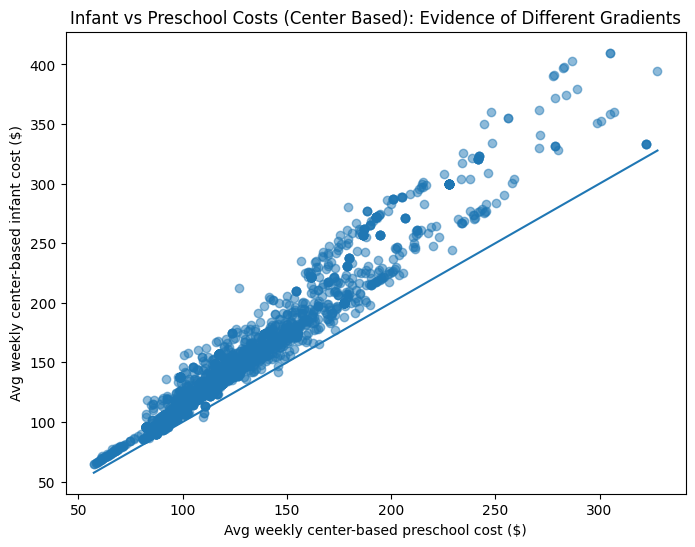

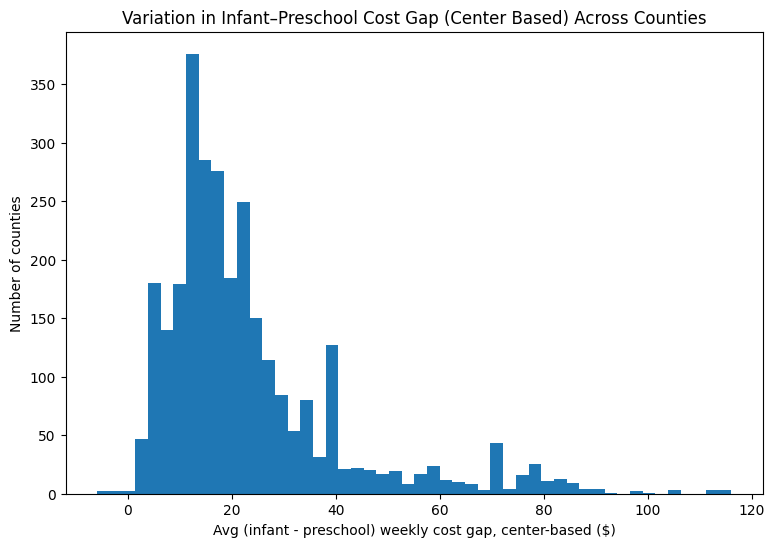

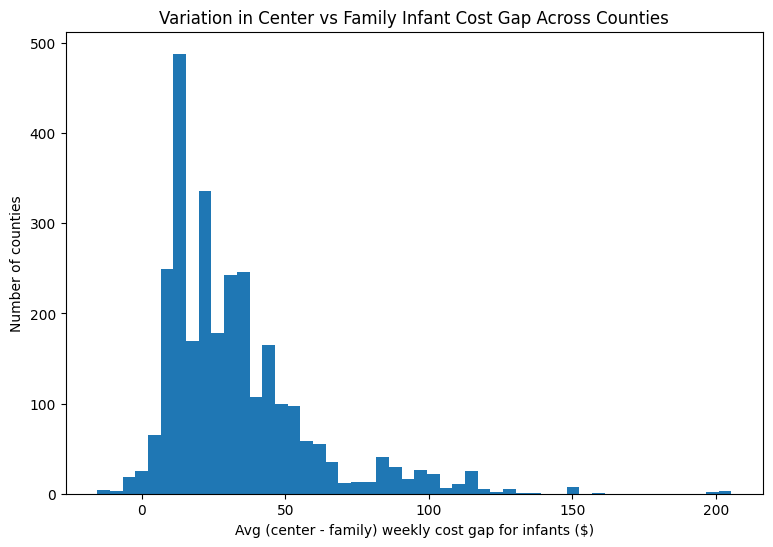

In [5]:
# 2) Build "gap" features to capture pricing structure (regimes)
#    - Age gradient within center-based care
#    - Age gradient within family childcare
#    - Center vs family gap for infant and preschool

df_gaps = df_avg.copy()

df_gaps["gap_center_infant_minus_preschool"] = df_gaps["mc_infant"] - df_gaps["mc_preschool"]
df_gaps["gap_family_infant_minus_preschool"] = df_gaps["mfcc_infant"] - df_gaps["mfcc_preschool"]

df_gaps["gap_infant_center_minus_family"] = df_gaps["mc_infant"] - df_gaps["mfcc_infant"]
df_gaps["gap_preschool_center_minus_family"] = df_gaps["mc_preschool"] - df_gaps["mfcc_preschool"]

# Drop rows missing any of the key fields for cleaner plots
key_cols = ["mc_infant","mc_preschool","mfcc_infant","mfcc_preschool","gap_center_infant_minus_preschool","gap_family_infant_minus_preschool", "gap_infant_center_minus_family","gap_preschool_center_minus_family"]
df_plot = df_gaps.dropna(subset=key_cols).copy()

# Plot A: Age gradient (Infant vs Preschool) — Center-based shows whether counties have steep vs flat gradients

plt.figure(figsize=(8,6))
plt.scatter(df_plot["mc_preschool"], df_plot["mc_infant"], alpha=0.5)
plt.plot([df_plot["mc_preschool"].min(), df_plot["mc_preschool"].max()],
         [df_plot["mc_preschool"].min(), df_plot["mc_preschool"].max()])
plt.xlabel("Avg weekly center-based preschool cost ($)")
plt.ylabel("Avg weekly center-based infant cost ($)")
plt.title("Infant vs Preschool Costs (Center Based): Evidence of Different Gradients")
plt.show()

# Plot B: Distribution of age gradient (Center based) directly visualizes how the infant-preschool gap varies across counties

plt.figure(figsize=(9,6))
plt.hist(df_plot["gap_center_infant_minus_preschool"], bins=50)
plt.xlabel("Avg (infant - preschool) weekly cost gap, center-based ($)")
plt.ylabel("Number of counties")
plt.title("Variation in Infant–Preschool Cost Gap (Center Based) Across Counties")
plt.show()

# Plot C: Center vs Family gap (Infant) shows if counties have large vs small provider type differences
plt.figure(figsize=(9,6))
plt.hist(df_plot["gap_infant_center_minus_family"], bins=50)
plt.xlabel("Avg (center - family) weekly cost gap for infants ($)")
plt.ylabel("Number of counties")
plt.title("Variation in Center vs Family Infant Cost Gap Across Counties")
plt.show()

Illustrates that differences between infant and preschool costs, as well as between center-based and family childcare, vary widely across counties. While some counties exhibit relatively flat pricing structures, others show steep age-based gradients and large provider-type gaps. The wide dispersion and heavy right tails of these gap distributions, together with the two-dimensional pricing regime map, indicate the presence of multiple distinct childcare pricing regimes rather than a single national pattern. These observations motivate our focus on uncovering latent county types based on childcare cost structures.

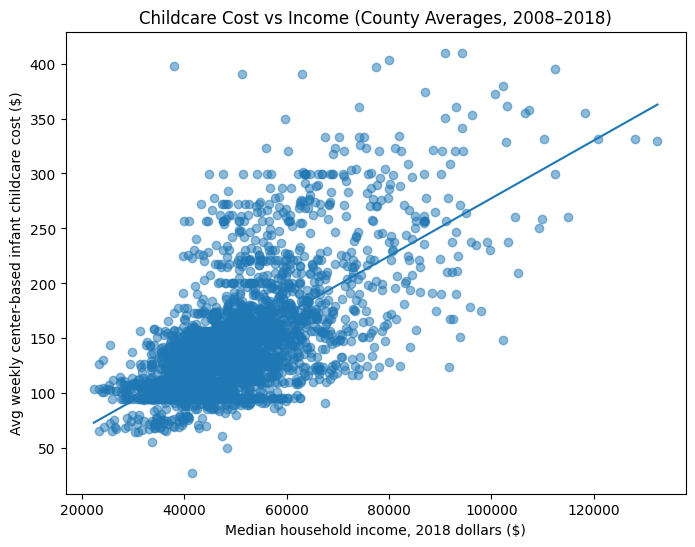

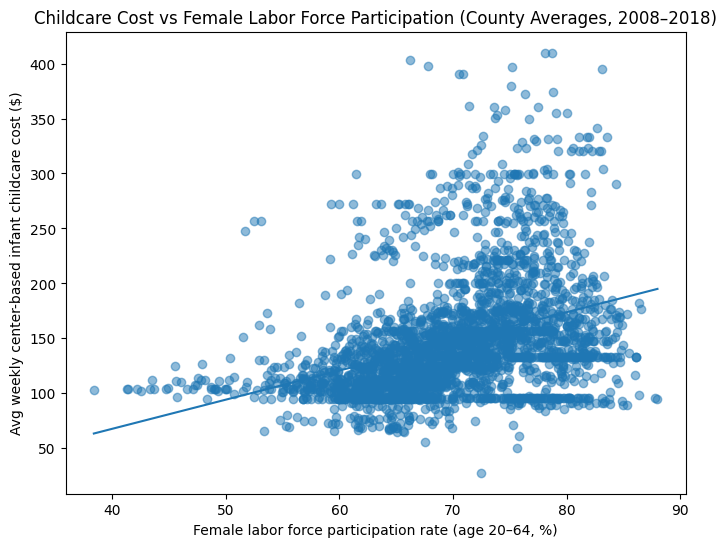

In [6]:
# county-level averages across years (one row per county)
df_avg = (df.groupby("county_fips_code").mean(numeric_only=True).reset_index())
plot_df = df_avg[["mc_infant", "mhi_2018", "flfpr_20to64"]].dropna().copy()
x_income = plot_df["mhi_2018"]
x_lfp    = plot_df["flfpr_20to64"]
y_cost   = plot_df["mc_infant"]

# helper to draw a simple best-fit line
def add_best_fit_line(x, y):
    m, b = np.polyfit(x, y, 1)
    xs = np.linspace(x.min(), x.max(), 200)
    plt.plot(xs, m*xs + b)


# plot A: Cost vs Income

plt.figure(figsize=(8,6))
plt.scatter(x_income, y_cost, alpha=0.5)
add_best_fit_line(x_income, y_cost)
plt.xlabel("Median household income, 2018 dollars ($)")
plt.ylabel("Avg weekly center-based infant childcare cost ($)")
plt.title("Childcare Cost vs Income (County Averages, 2008–2018)")
plt.show()


# Plot B: Cost vs Female Labor Force Participation

plt.figure(figsize=(8,6))
plt.scatter(x_lfp, y_cost, alpha=0.5)
add_best_fit_line(x_lfp, y_cost)
plt.xlabel("Female labor force participation rate (age 20–64, %)")
plt.ylabel("Avg weekly center-based infant childcare cost ($)")
plt.title("Childcare Cost vs Female Labor Force Participation (County Averages, 2008–2018)")
plt.show()

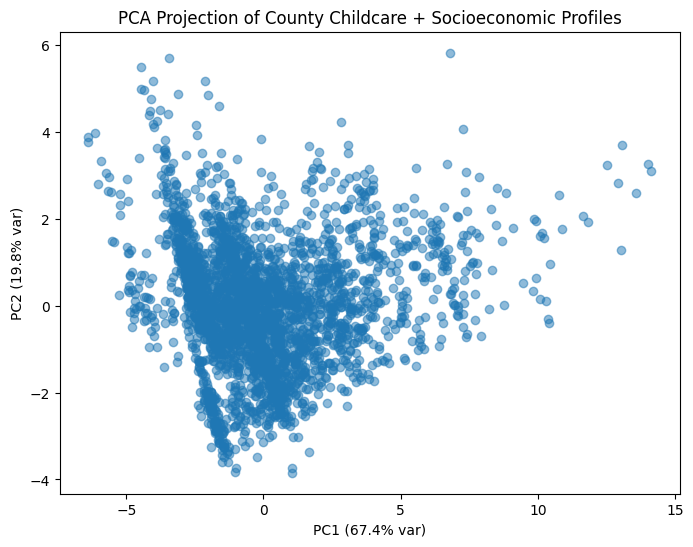

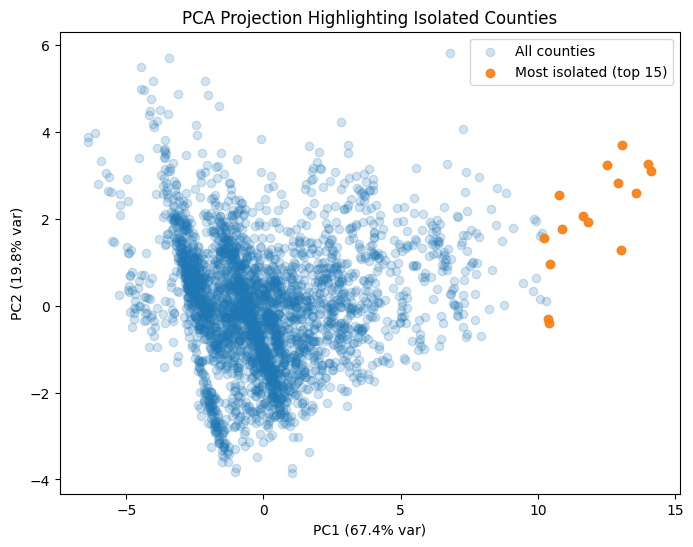

Most isolated counties (county_fips_code):
[ 8097 51610 51107 56039  6081  6075  6041 36079 36119 51013 36103 36087
 36059 25017 25021]

Most isolated counties (name):


,county_fips_code,county_name,state_name
0,8097,Pitkin County,Colorado
1,51610,Falls Church city,Virginia
2,51107,Loudoun County,Virginia
3,56039,Teton County,Wyoming
4,6081,San Mateo County,California
5,6075,San Francisco County,California
6,6041,Marin County,California
7,36079,Putnam County,New York
8,36119,Westchester County,New York
9,51013,Arlington County,Virginia


In [7]:
# County-level averages (one row per county)
df_avg = (df.groupby("county_fips_code").mean(numeric_only=True).reset_index())

# Select childcare cost + socioeconomic variables for a "county profile"
feature_cols = [
    # childcare costs (center + family, age groups)
    "mc_infant", "mc_toddler", "mc_preschool",
    "mfcc_infant", "mfcc_toddler", "mfcc_preschool",
    # socioeconomics
    "mhi_2018", "flfpr_20to64", "unr_20to64", "pr_p"
]

X = df_avg[feature_cols].copy()

# Impute missing values + standardize (important for PCA/UMAP)
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_imputed = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imputed)


# Plot A: PCA projection (2D)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("PCA Projection of County Childcare + Socioeconomic Profiles")
plt.show()

# Identify "isolated" counties in PCA space (largest distance from center)
pca_dist = np.sqrt(X_pca[:,0]**2 + X_pca[:,1]**2)
top_idx = np.argsort(pca_dist)[-15:]  # top 15 most isolated

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.2, label="All counties")
plt.scatter(X_pca[top_idx,0], X_pca[top_idx,1], alpha=0.9, label="Most isolated (top 15)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("PCA Projection Highlighting Isolated Counties")
plt.legend()
plt.show()

# Show which counties are isolated (FIPS list; join names if you merged counties info earlier)
isolated_fips = df_avg.loc[top_idx, "county_fips_code"].values
print("Most isolated counties (county_fips_code):")
print(isolated_fips)
if {"county_name", "state_name"}.issubset(df.columns):
    fips_to_name = (
        df[["county_fips_code", "county_name", "state_name"]]
        .drop_duplicates()
        .set_index("county_fips_code")
    )
    print("\nMost isolated counties (name):")
    display(fips_to_name.loc[isolated_fips].reset_index())


# **3. EDA & Preprocessing Updates**

In [8]:
# County-level dataset (one row per county)
df_avg = (df.groupby("county_fips_code").mean(numeric_only=True).reset_index())
X = df_avg[feature_cols].copy()

## 3.1 Data Completeness and Distributional Overview of County-Level Features

In [9]:
# Naan + summary stats (for Section 2 write-up)
missing_rate = X.isna().mean().sort_values(ascending=False)
print("Missing rate by feature:")
print(missing_rate)

summary_stats = X.describe().T[["mean", "std", "min", "max"]]
print("\nSummary stats (county averages):")
print(summary_stats)

Missing rate by feature:
mfcc_toddler      0.080471
mfcc_infant       0.080471
mfcc_preschool    0.080471
mc_infant         0.076336
mc_toddler        0.076336
mc_preschool      0.076336
mhi_2018          0.000000
flfpr_20to64      0.000000
unr_20to64        0.000000
pr_p              0.000000
dtype: float64

Summary stats (county averages):
                        mean           std           min            max
mc_infant         147.495269     53.290995     27.730000     409.881818
mc_toddler        132.758219     44.240447     21.540000     377.818182
mc_preschool      124.083381     38.939376     21.540000     327.800000
mfcc_infant       114.813778     32.712787     53.803333     299.432727
mfcc_toddler      108.535699     29.949447     48.062222     291.130000
mfcc_preschool    105.879820     28.748923     45.820000     281.260000
mhi_2018        50449.538443  13029.445529  22306.048182  132466.600000
flfpr_20to64       70.088699      7.244722     38.381818      96.518182
unr_20to

Missing values are limited to childcare price variables, with approximately 7–8 percent of county-level averages missing, while income, labor force participation, unemployment, and poverty measures are complete. Results indicate dispersion in childcare prices across counties, particularly for center-based infant care, where weekly averages range from under 30 to 400 dollars.

## 3.2 Pricing Structure Features: Age-Based and Care-Type Cost Differentials

In [10]:
# Construct pricing structure features (gradients + gaps)
# ------------------------------------------------------------
df_avg["infant_center_preschool_gap"] = df_avg["mc_infant"] - df_avg["mc_preschool"]
df_avg["infant_family_preschool_gap"] = df_avg["mfcc_infant"] - df_avg["mfcc_preschool"]
df_avg["infant_center_family_gap"] = df_avg["mc_infant"] - df_avg["mfcc_infant"]
df_avg["toddler_center_family_gap"] = df_avg["mc_toddler"] - df_avg["mfcc_toddler"]
df_avg["preschool_center_family_gap"] = df_avg["mc_preschool"] - df_avg["mfcc_preschool"]

print("\nPricing structure features summary:")
print(df_avg[["infant_center_preschool_gap","infant_family_preschool_gap", "infant_center_family_gap", "toddler_center_family_gap","preschool_center_family_gap"]].describe())


Pricing structure features summary:
       infant_center_preschool_gap  infant_family_preschool_gap  \
count                  2904.000000                  2891.000000   
mean                     23.411888                     8.933959   
std                      17.883384                     7.448850   
min                     -10.480000                   -52.644000   
25%                      12.668409                     4.288000   
50%                      17.712273                     7.500000   
75%                      27.671000                    11.670727   
max                     116.140000                    46.620000   

       infant_center_family_gap  toddler_center_family_gap  \
count               2885.000000                2885.000000   
mean                  32.897465                  24.478364   
std                   25.891113                  19.517027   
min                  -15.475139                 -27.833000   
25%                   14.619000                  

Constructed pricing structure features show substantial cross-county dispersion, with infant–preschool center-based price gaps averaging about 23 dollars/week but ranging from negative values to over 116 dollars. Center–family price gaps are positive on average but also span large ranges, including negative values, confirming that differences in pricing structure form a continuum rather than discrete categories.

# **4. Unsupervised Analysis: PCA and Clustering**

> Add blockquote



## 4.1 Dimensionality Reduction via PCA

In [11]:
# PCA setup + variance explained
# Fit PCA (keep 5 components for variance reporting)
pca = PCA(n_components=5, random_state=42)
X_pca = pca.fit_transform(X_scaled)

explained = pca.explained_variance_ratio_
print("\nExplained variance ratio (PC1..PC5):")
print(np.round(explained, 4))
print("\nCumulative explained variance:")
print(np.round(np.cumsum(explained), 4))


Explained variance ratio (PC1..PC5):
[0.6735 0.1976 0.0463 0.0399 0.0194]

Cumulative explained variance:
[0.6735 0.8711 0.9174 0.9573 0.9768]


In [12]:
# PCA loadings table
loadings = pd.DataFrame(
    pca.components_.T,
    index=feature_cols,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

loadings

,PC1,PC2,PC3,PC4,PC5
mc_infant,0.363672,0.164539,0.018758,-0.081045,-0.397240
mc_toddler,0.366055,0.142226,0.071502,-0.127145,-0.403146
mc_preschool,0.367235,0.146820,0.038375,-0.114046,-0.392168
mfcc_infant,0.363435,0.175460,-0.090946,-0.025040,0.400463
mfcc_toddler,0.365619,0.172581,-0.068156,-0.061845,0.407722
mfcc_preschool,0.366284,0.162814,-0.071653,-0.071381,0.398279
mhi_2018,0.300984,-0.270251,-0.132046,0.672088,-0.130730
flfpr_20to64,0.201939,-0.439709,0.839720,-0.168301,0.135555
unr_20to64,-0.114905,0.573703,0.475131,0.604818,0.046276
pr_p,-0.233206,0.498547,0.163392,-0.329971,-0.055105


In [13]:
# Interpret PC1 and PC2 using top loadings
def top_loadings(pc_name, k=5):
    s = loadings[pc_name]
    top_pos = s.sort_values(ascending=False).head(k)
    top_neg = s.sort_values(ascending=True).head(k)
    return top_pos, top_neg

pc1_pos, pc1_neg = top_loadings("PC1", k=5)
pc2_pos, pc2_neg = top_loadings("PC2", k=5)

print("\n--- PC1 interpretation (top +/- loadings) ---")
print("PC1 positive (higher PC1 -> higher in these features):")
print(np.round(pc1_pos, 3))
print("\nPC1 negative (higher PC1 -> lower in these features):")
print(np.round(pc1_neg, 3))

print("\n--- PC2 interpretation (top +/- loadings) ---")
print("PC2 positive (higher PC2 -> higher in these features):")
print(np.round(pc2_pos, 3))
print("\nPC2 negative (higher PC2 -> lower in these features):")
print(np.round(pc2_neg, 3))



--- PC1 interpretation (top +/- loadings) ---
PC1 positive (higher PC1 -> higher in these features):
mc_preschool      0.367
mfcc_preschool    0.366
mc_toddler        0.366
mfcc_toddler      0.366
mc_infant         0.364
Name: PC1, dtype: float64

PC1 negative (higher PC1 -> lower in these features):
pr_p           -0.233
unr_20to64     -0.115
flfpr_20to64    0.202
mhi_2018        0.301
mfcc_infant     0.363
Name: PC1, dtype: float64

--- PC2 interpretation (top +/- loadings) ---
PC2 positive (higher PC2 -> higher in these features):
unr_20to64      0.574
pr_p            0.499
mfcc_infant     0.175
mfcc_toddler    0.173
mc_infant       0.165
Name: PC2, dtype: float64

PC2 negative (higher PC2 -> lower in these features):
flfpr_20to64     -0.440
mhi_2018         -0.270
mc_toddler        0.142
mc_preschool      0.147
mfcc_preschool    0.163
Name: PC2, dtype: float64


In [14]:
# Correlate PC scores with original features (sanity check)

pc_scores = pd.DataFrame(X_pca[:, :2], columns=["PC1_score", "PC2_score"])
X_df = pd.DataFrame(X_scaled, columns=feature_cols)

corr_pc1 = X_df.corrwith(pc_scores["PC1_score"]).sort_values(ascending=False)
corr_pc2 = X_df.corrwith(pc_scores["PC2_score"]).sort_values(ascending=False)

print("\nTop correlations with PC1 score:")
print(np.round(corr_pc1.head(6), 3))

print("\nTop correlations with PC2 score:")
print(np.round(corr_pc2.head(6), 3))


Top correlations with PC1 score:
mc_preschool      0.953
mfcc_preschool    0.951
mc_toddler        0.950
mfcc_toddler      0.949
mc_infant         0.944
mfcc_infant       0.943
dtype: float64

Top correlations with PC2 score:
unr_20to64        0.806
pr_p              0.701
mfcc_infant       0.247
mfcc_toddler      0.243
mc_infant         0.231
mfcc_preschool    0.229
dtype: float64


After median imputation and standardization, principal component analysis (PCA)indicates that the first two components explain approximately 87 percent of total variation in county childcare and socioeconomic profiles. PCA shows that most cross-county variation is driven by a dominant cost dimension loading uniformly on childcare prices, with a secondary component capturing socioeconomic conditions (unemployment and poverty rate) independent of overall price level.

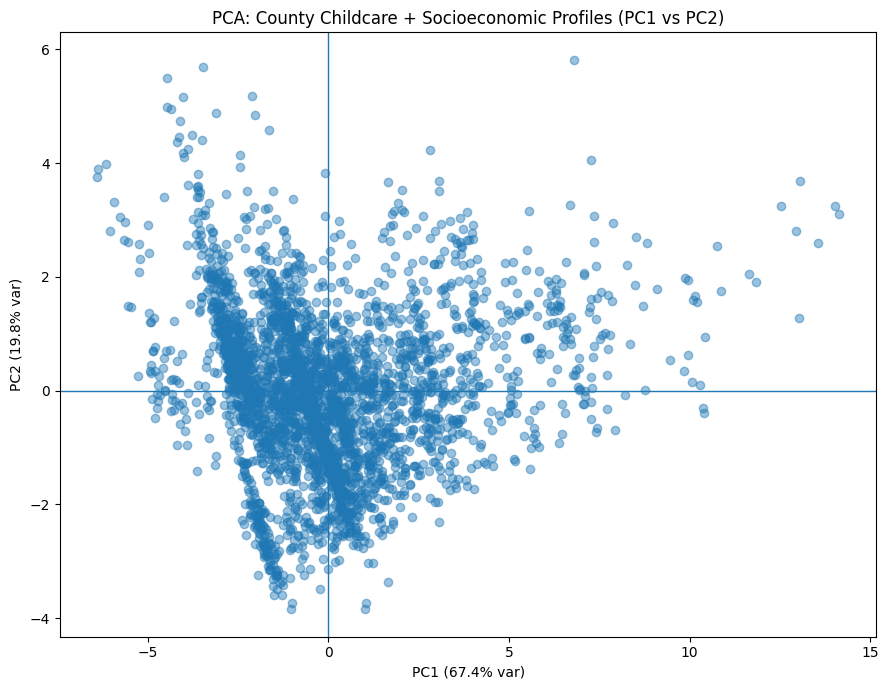

In [15]:
# Plot PC1 vs PC2 (main structure plot)

plt.figure(figsize=(9, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.45)

plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)

plt.xlabel(f"PC1 ({explained[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({explained[1]*100:.1f}% var)")
plt.title("PCA: County Childcare + Socioeconomic Profiles (PC1 vs PC2)")
plt.tight_layout()
plt.show()

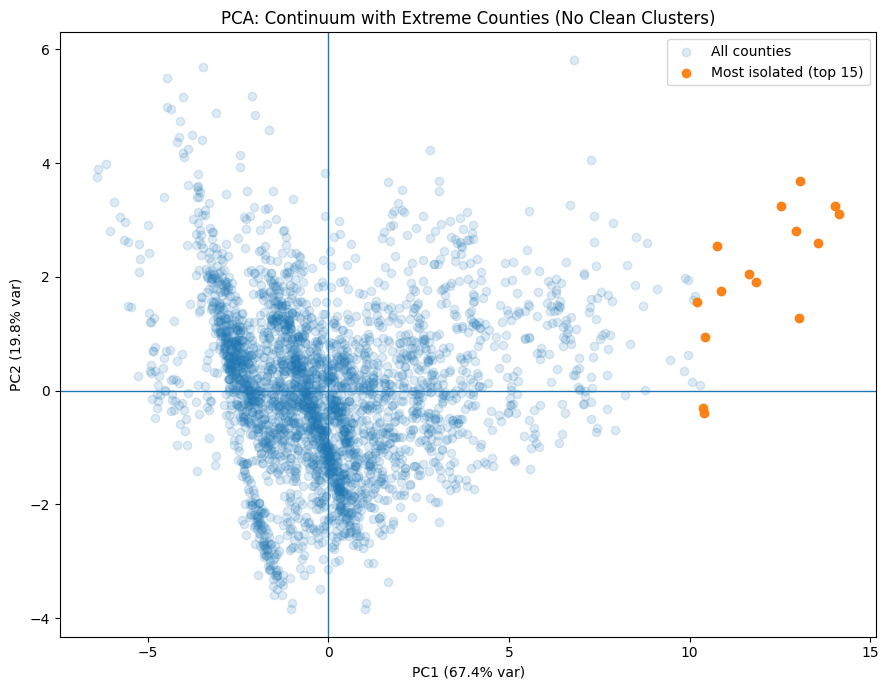

In [16]:
# Identify extreme / isolated counties
pca_dist = np.sqrt(X_pca[:, 0]**2 + X_pca[:, 1]**2)
top_k = 15
top_idx = np.argsort(pca_dist)[-top_k:]

# Plot extremes vs rest
plt.figure(figsize=(9, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.15, label="All counties")
plt.scatter(X_pca[top_idx, 0], X_pca[top_idx, 1], alpha=0.95, label=f"Most isolated (top {top_k})")

plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)

plt.xlabel(f"PC1 ({explained[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({explained[1]*100:.1f}% var)")
plt.title("PCA: Continuum with Extreme Counties (No Clean Clusters)")
plt.legend()
plt.tight_layout()
plt.show()

## 4.2 Outliers in PCA Space

In [17]:
# Identify isolated counties in PCA space (PC1-PC2 distance)
pca_dist = np.sqrt(X_pca[:, 0]**2 + X_pca[:, 1]**2)

print("\nDistance percentiles in PCA space (PC1-PC2):")
print(pd.Series(np.percentile(pca_dist, [50, 75, 90, 95, 99]),
                index=["50%", "75%", "90%", "95%", "99%"]))

top_k = 15
top_idx = np.argsort(pca_dist)[-top_k:]

isolated = df_avg.loc[top_idx, ["county_fips_code"] + feature_cols].copy()
print(f"\nTop {top_k} most isolated counties (FIPS + features):")
print(isolated)


Distance percentiles in PCA space (PC1-PC2):
50%    2.118031
75%    2.988493
90%    4.334123
95%    5.734212
99%    8.500464
dtype: float64

Top 15 most isolated counties (FIPS + features):
      county_fips_code   mc_infant  mc_toddler  mc_preschool  mfcc_infant  \
294               8097  333.550000  306.550000    322.200000   225.000000   
2927             51610  331.600000  278.600000    278.600000   229.000000   
2873             51107  329.700000  271.100000    271.100000   229.000000   
3140             56039  290.776000  257.304000    254.176000   277.920000   
227               6081  371.895455  278.659091    278.659091   247.020000   
224               6075  374.293636  283.700000    283.700000   257.549091   
207               6041  379.463636  289.380909    289.380909   260.241818   
1868             36079  328.630000  305.160000    279.880000   267.290000   
1888             36119  350.690000  325.640000    298.670000   285.960000   
2827             51013  394.800000  327

Distance percentiles in the two-dimensional PCA space indicate that most counties cluster close to the center, while structural extremity is concentrated in a very small upper tail, with the top 5 percent of counties located more than 5.7 standardized units from the center. The most isolated counties are characterized by high childcare prices across all provider types and age groups, combined with relatively high income levels, which suggests that structural extremity arises from consistently elevated cost environments rather than from isolated price gaps or atypical gradients.

In [18]:
# Profile isolated counties vs overall counties
isolated_profile = isolated[feature_cols].describe().T[["mean", "min", "max"]]
overall_profile = df_avg[feature_cols].describe().T[["mean", "min", "max"]]

print("\nIsolated counties profile (mean/min/max):")
print(isolated_profile)

print("\nOverall counties profile (mean/min/max):")
print(overall_profile)


Isolated counties profile (mean/min/max):
                        mean           min            max
mc_infant         358.439491    290.776000     409.881818
mc_toddler        311.628691    257.304000     377.818182
mc_preschool      293.756521    254.176000     327.800000
mfcc_infant       268.658424    225.000000     299.432727
mfcc_toddler      254.137842    196.500000     291.130000
mfcc_preschool    248.060739    196.500000     281.260000
mhi_2018        99519.537212  74054.930000  132466.600000
flfpr_20to64       77.750303     73.563636      84.310909
unr_20to64          5.078485      2.641818       6.490909
pr_p                7.455394      3.330909      12.927273

Overall counties profile (mean/min/max):
                        mean           min            max
mc_infant         147.495269     27.730000     409.881818
mc_toddler        132.758219     21.540000     377.818182
mc_preschool      124.083381     21.540000     327.800000
mfcc_infant       114.813778     53.803333   

Isolated counties are characterized by high childcare prices across all care types and ages, with mean values more than double those observed nationally. Compared with the overall sample, these counties also exhibit higher income levels, and lower unemployment and poverty rates, indicating that extremity arises from consistent differences across multiple dimensions rather than from single outlier variables.

## 4.3 Clustering Attempt and Diagnostic Failure (KMeans)

In [19]:
# Already have:
# X_scaled (standardized features)
# feature_cols (list of feature names)
# df_avg (county-level df)

pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_scaled)

print("PCA for visualization ready.")
print("Explained variance:", np.round(pca2.explained_variance_ratio_, 4))

PCA for visualization ready.
Explained variance: [0.6735 0.1976]


In [20]:
# Run KMeans for k = 2…6 + silhouette + inertia + size checks
ks = range(2, 7)
rows = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=25)
    labels = km.fit_predict(X_scaled)

    sil = silhouette_score(X_scaled, labels)
    sizes = pd.Series(labels).value_counts().sort_index()

    rows.append({
        "k": k,
        "silhouette": sil,
        "inertia": km.inertia_,
        "min_cluster_size": int(sizes.min()),
        "max_cluster_size": int(sizes.max())
    })

results_df = pd.DataFrame(rows).sort_values("k")
display(results_df)

,k,silhouette,inertia,min_cluster_size,max_cluster_size
0,2,0.438097,18399.623956,668,2476
1,3,0.303219,13399.309948,539,1512
2,4,0.285874,11103.562124,178,1344
3,5,0.232171,9877.571181,177,1035
4,6,0.229349,8986.673209,151,732


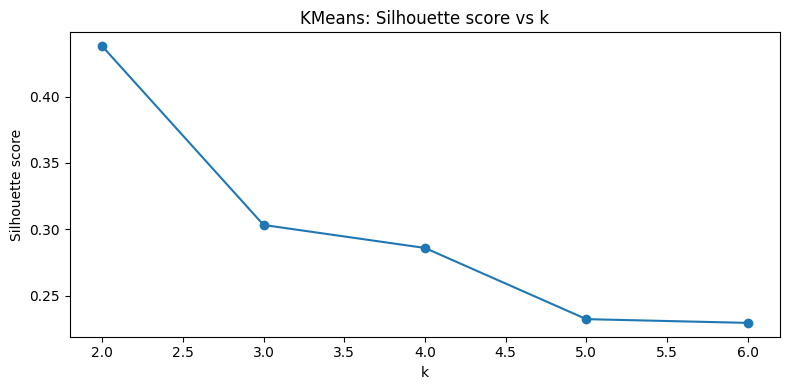

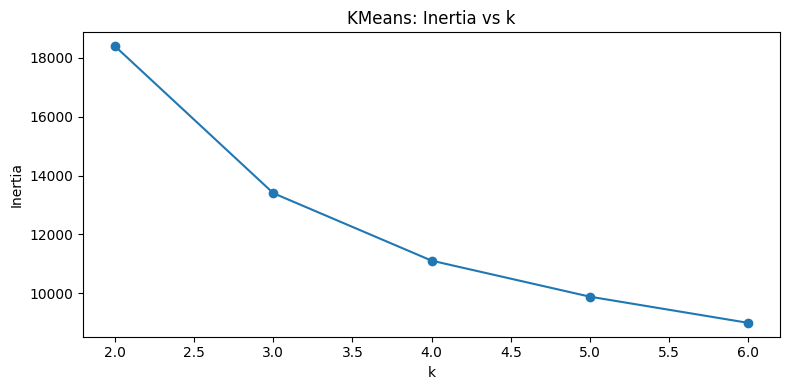

In [21]:
# Plot silhouette and inertia vs k (diagnostic)
plt.figure(figsize=(8, 4))
plt.plot(results_df["k"], results_df["silhouette"], marker="o")
plt.title("KMeans: Silhouette score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(results_df["k"], results_df["inertia"], marker="o")
plt.title("KMeans: Inertia vs k")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()

In [22]:
# Choose a k to inspect (systematic: max silhouette)

k_choice = int(results_df.loc[results_df["silhouette"].idxmax(), "k"])
print(f"Chosen k for inspection: k={k_choice}")

km = KMeans(n_clusters=k_choice, random_state=42, n_init=25)
labels = km.fit_predict(X_scaled)

cluster_sizes = pd.Series(labels).value_counts().sort_index()
print("\nCluster sizes:")
display(cluster_sizes.to_frame("n_counties"))

Chosen k for inspection: k=2

Cluster sizes:


,n_counties
0,2476
1,668


In [23]:
# Centroids table (standardized feature space)

centroids_scaled = pd.DataFrame(km.cluster_centers_, columns=feature_cols)
display(centroids_scaled.style.format("{:.3f}").set_caption("KMeans centroids (STANDARDIZED feature space)"))

,mc_infant,mc_toddler,mc_preschool,mfcc_infant,mfcc_toddler,mfcc_preschool,mhi_2018,flfpr_20to64,unr_20to64,pr_p
0,-0.406,-0.407,-0.409,-0.404,-0.401,-0.399,-0.286,-0.155,0.043,0.176
1,1.505,1.507,1.517,1.496,1.485,1.478,1.061,0.574,-0.159,-0.654


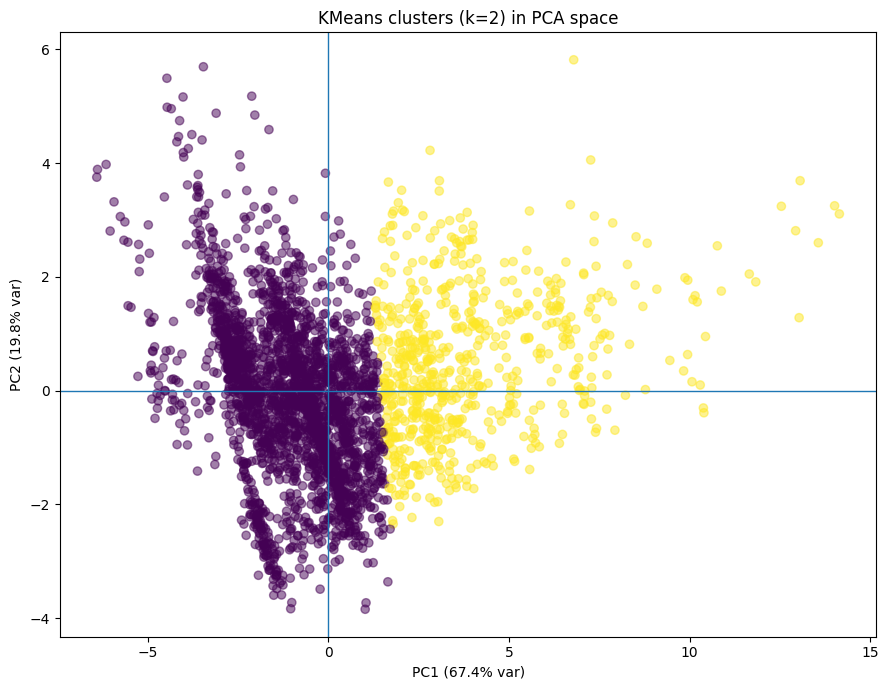

In [24]:
# Plot clusters in PCA space (the “overlap” evidence)

plt.figure(figsize=(9, 7))
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=labels, alpha=0.5)

plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)

plt.title(f"KMeans clusters (k={k_choice}) in PCA space")
plt.xlabel(f"PC1 ({pca2.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca2.explained_variance_ratio_[1]*100:.1f}% var)")
plt.tight_layout()
plt.show()

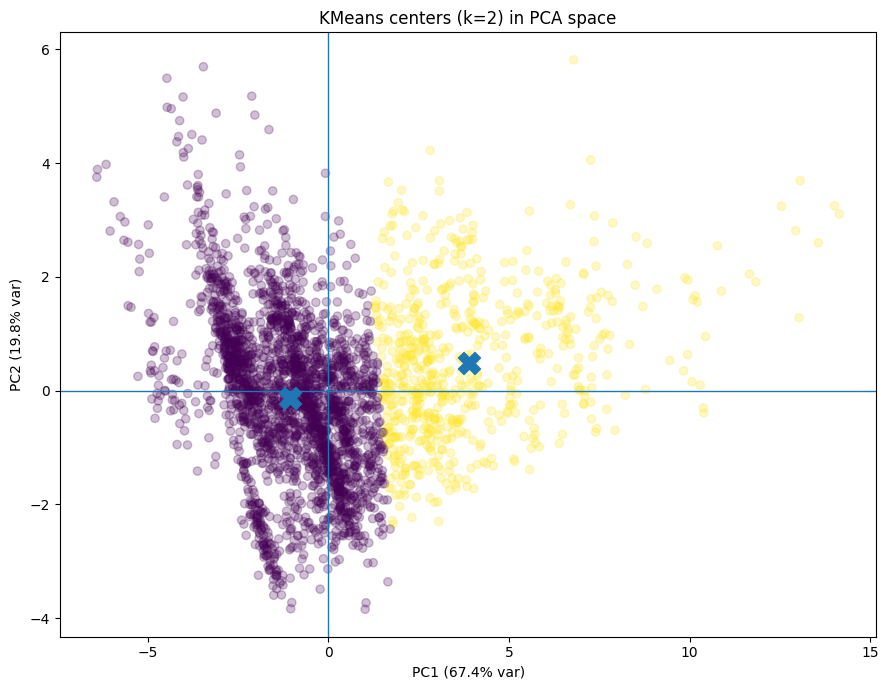

In [25]:
# Plot KMeans centers in PCA space (shows “mostly along PC1”)

centers_pca = pca2.transform(km.cluster_centers_)

plt.figure(figsize=(9, 7))
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=labels, alpha=0.25)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], marker="X", s=250)

plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)

plt.title(f"KMeans centers (k={k_choice}) in PCA space")
plt.xlabel(f"PC1 ({pca2.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca2.explained_variance_ratio_[1]*100:.1f}% var)")
plt.tight_layout()
plt.show()

##4.4 Distance-Based Extremity in PCA Space (Outlier Detection)


In [26]:
# Build PC1/PC2 distance from the center
# X_pca exists and contains PCA scores with PC1 in col 0, PC2 in col 1
pc1 = X_pca[:, 0]
pc2 = X_pca[:, 1]

# Euclidean distance from origin (0,0) in PC1–PC2 space
dist_pc12 = np.sqrt(pc1**2 + pc2**2)

# Attach to df_avg (county-level)
df_ext = df_avg.copy()
df_ext["PC1"] = pc1
df_ext["PC2"] = pc2
df_ext["dist_pc12"] = dist_pc12

df_ext[["county_fips_code", "PC1", "PC2", "dist_pc12"]].head()

,county_fips_code,PC1,PC2,dist_pc12
0,1001,-0.759983,-1.186043,1.408642
1,1003,-0.562446,-0.766692,0.950875
2,1005,-3.540731,1.422624,3.815840
3,1007,-2.385764,-0.080016,2.387105
4,1009,-0.429082,0.364516,0.563012


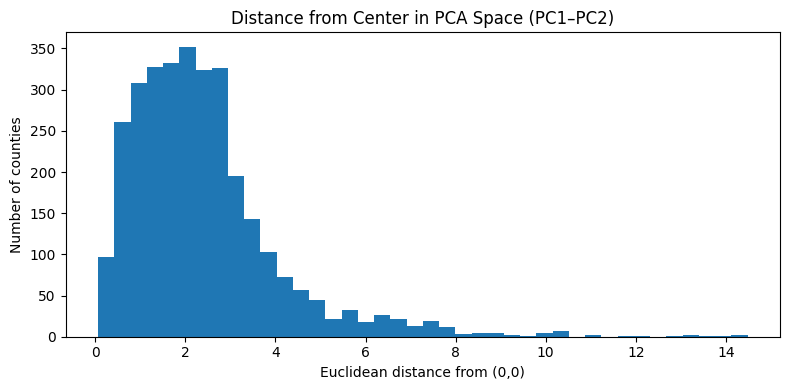

Distance percentiles in PC1–PC2 space:


,dist_pc12
50%,2.118031
75%,2.988493
90%,4.334123
95%,5.734212
99%,8.500464


In [27]:
# Show distribution of distances (histogram + percentiles)
plt.figure(figsize=(8, 4))
plt.hist(df_ext["dist_pc12"], bins=40)
plt.title("Distance from Center in PCA Space (PC1–PC2)")
plt.xlabel("Euclidean distance from (0,0)")
plt.ylabel("Number of counties")
plt.tight_layout()
plt.show()

# Key percentiles (useful for the write-up)
pct_levels = [50, 75, 90, 95, 99]
pct_vals = np.percentile(df_ext["dist_pc12"], pct_levels)

dist_summary = pd.Series(pct_vals, index=[f"{p}%" for p in pct_levels])
print("Distance percentiles in PC1–PC2 space:")
display(dist_summary.to_frame("dist_pc12"))

In [28]:
# Flag extreme counties by top 1%, 5%
# Thresholds
thr_99 = np.percentile(df_ext["dist_pc12"], 99)  # top 1%
thr_95 = np.percentile(df_ext["dist_pc12"], 95)  # top 5%

df_ext["extreme_top1pct"] = df_ext["dist_pc12"] >= thr_99
df_ext["extreme_top5pct"] = df_ext["dist_pc12"] >= thr_95

print("Counts:")
print("Top 1% extreme counties:", df_ext["extreme_top1pct"].sum())
print("Top 5% extreme counties:", df_ext["extreme_top5pct"].sum())

# Preview the extreme counties (top 1%)
df_ext.loc[df_ext["extreme_top1pct"], ["county_fips_code", "PC1", "PC2", "dist_pc12"]].sort_values("dist_pc12", ascending=False).head(15)

Counts:
Top 1% extreme counties: 32
Top 5% extreme counties: 158


,county_fips_code,PC1,PC2,dist_pc12
1228,25021,14.144441,3.105794,14.481408
1226,25017,14.012506,3.248873,14.384210
1858,36059,13.562265,2.599030,13.809055
1872,36087,13.058480,3.689929,13.569800
1880,36103,12.934679,2.810157,13.236424
2827,51013,13.030731,1.281233,13.093567
1888,36119,12.538995,3.240283,12.950901
1868,36079,11.831936,1.910517,11.985190
207,6041,11.652117,2.049250,11.830945
224,6075,10.767540,2.544695,11.064149


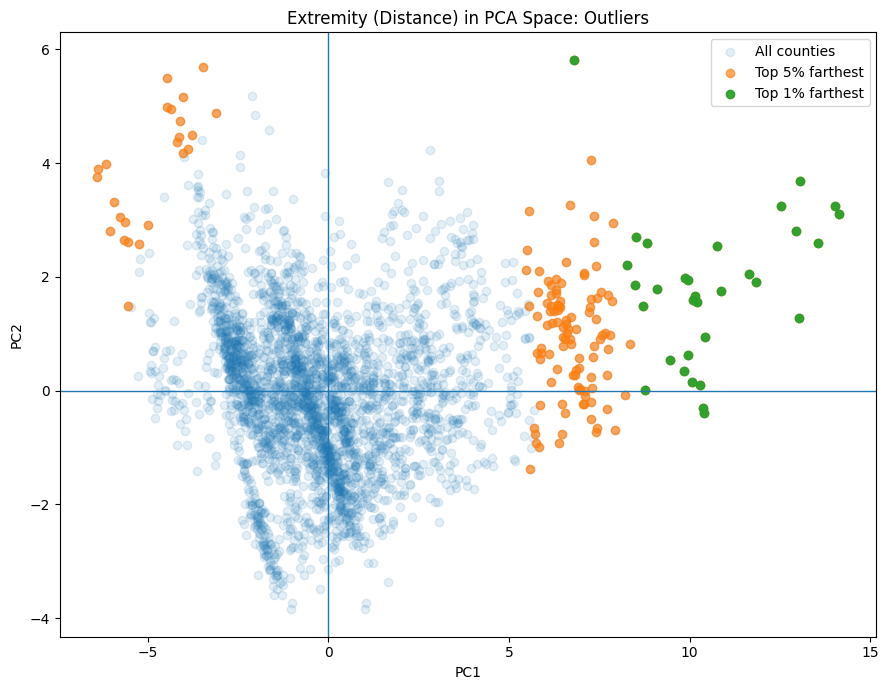

In [29]:
# Visualize extremes in PCA space
plt.figure(figsize=(9, 7))

# All counties (faint)
plt.scatter(df_ext["PC1"], df_ext["PC2"], alpha=0.12, label="All counties")

# Top 5% (medium)
mask5 = df_ext["extreme_top5pct"]
plt.scatter(df_ext.loc[mask5, "PC1"], df_ext.loc[mask5, "PC2"], alpha=0.65, label="Top 5% farthest")

# Top 1% (strong)
mask1 = df_ext["extreme_top1pct"]
plt.scatter(df_ext.loc[mask1, "PC1"], df_ext.loc[mask1, "PC2"], alpha=0.95, label="Top 1% farthest")

plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)

plt.title("Extremity (Distance) in PCA Space: Outliers")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
# Show why top 1–5% are different
# Choose which group to profile: top 5% or top 1%
group_mask = df_ext["extreme_top5pct"]   # change to extreme_top1pct if desired

overall_mean = df_ext[feature_cols].mean()
extreme_mean = df_ext.loc[group_mask, feature_cols].mean()

# Difference in original units
diff = extreme_mean - overall_mean

# Standardized difference (effect size-ish): diff / overall std
overall_std = df_ext[feature_cols].std(ddof=0)
std_diff = diff / overall_std

profile = pd.DataFrame({
    "overall_mean": overall_mean,
    "extreme_mean": extreme_mean,
    "diff": diff,
    "std_diff": std_diff
}).sort_values("std_diff", ascending=False)

display(profile)

,overall_mean,extreme_mean,diff,std_diff
mc_preschool,124.083381,214.564775,90.481394,2.324048
mc_infant,147.495269,269.830531,122.335261,2.296004
mc_toddler,132.758219,233.326981,100.568761,2.273623
mfcc_preschool,105.879820,168.037998,62.158179,2.162479
mfcc_toddler,108.535699,172.571890,64.036191,2.138513
mfcc_infant,114.813778,183.977988,69.164210,2.114652
mhi_2018,50449.538443,71330.829287,20881.290844,1.602878
flfpr_20to64,70.088699,73.786991,3.698292,0.510562
unr_20to64,6.899141,7.570524,0.671383,0.226622
pr_p,16.036426,14.158119,-1.878307,-0.302090


In [31]:
# Show the top 6 features that differ most in standardized terms
top_drivers = profile["std_diff"].abs().sort_values(ascending=False).head(6).index
print("Top drivers of extremity (largest |standardized difference|):")
display(profile.loc[top_drivers])

Top drivers of extremity (largest |standardized difference|):


,overall_mean,extreme_mean,diff,std_diff
mc_preschool,124.083381,214.564775,90.481394,2.324048
mc_infant,147.495269,269.830531,122.335261,2.296004
mc_toddler,132.758219,233.326981,100.568761,2.273623
mfcc_preschool,105.879820,168.037998,62.158179,2.162479
mfcc_toddler,108.535699,172.571890,64.036191,2.138513
mfcc_infant,114.813778,183.977988,69.164210,2.114652


# **5. M3 Integration**

##5.1 Hierarchical Clustering on Full Data


In M2, KMeans clustering (k=2) achieved a silhouette score of ~0.44 but produced a
heavily imbalanced split (2476 vs 668 counties) that merely separated a small group of
high-cost counties from the rest. The continuous gradient structure identified via PCA,
combined with the density of the core and the sparse tail of extreme counties, suggests
that KMeans, which assumes roughly spherical clusters, may not be the
right tool for this data topology.

Hierarchical clustering offers two key advantages for our integration analysis:

1. **The dendrogram is diagnostic.** Unlike KMeans (which only gives silhouette/inertia
   curves), the dendrogram visually reveals the merge structure. If there are natural
   breaks, we see large jumps in merge distance at specific heights. If merges are smooth
   and gradual, that provides independent evidence for Kai's continuous gradient finding
   from a completely different method.

2. **Linkage methods handle outliers differently.** Ward's linkage (most comparable to
   KMeans) minimizes within-cluster variance. Complete linkage is more sensitive to
   outlier separation and may naturally isolate the extreme counties that Kai's
   distance-based analysis identified, connecting hierarchical results directly to M2
   extremity findings.

We run this in PC1–PC2 space to be directly comparable to Kai's M2 KMeans results.


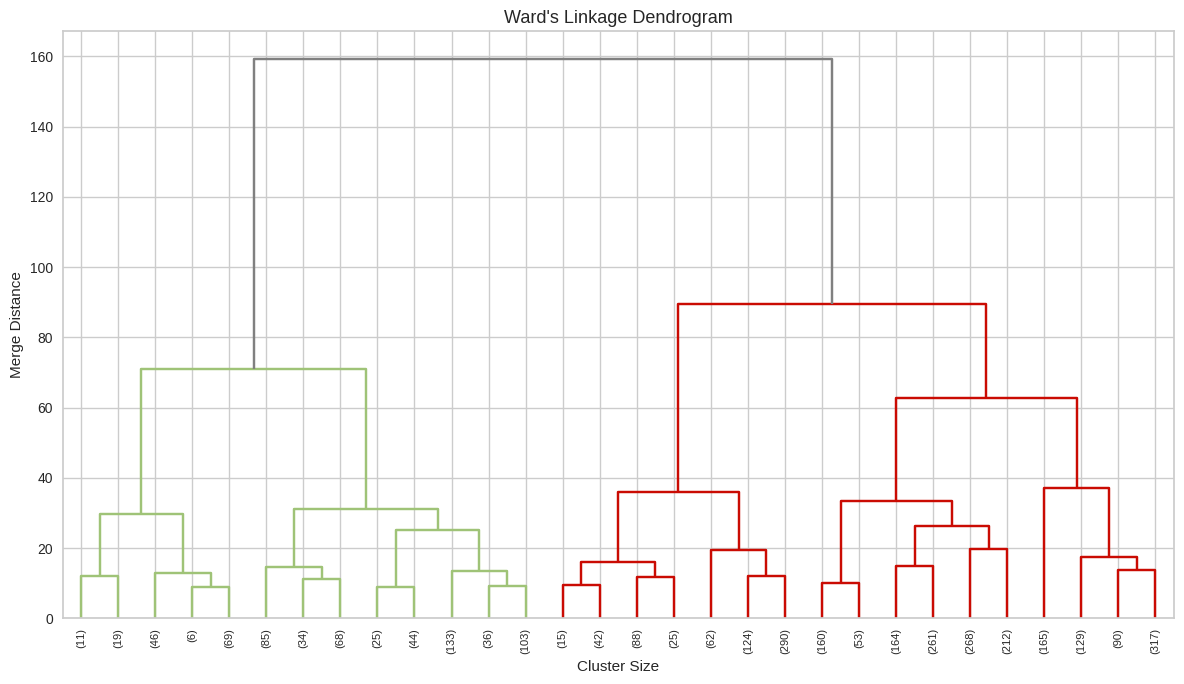

In [68]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import seaborn as sns

# Use PC1 and PC2 scores
X_hier = X_pca[:, :2]

# Compute Ward's linkage
Z = linkage(X_hier, 'ward')

# Dendrogram
plt.figure(figsize=(12, 7))
dendrogram(Z, truncate_mode='lastp',
           leaf_rotation=90, leaf_font_size=8,
           show_leaf_counts=True, above_threshold_color='gray')
plt.title("Ward's Linkage Dendrogram", fontsize=13)
plt.ylabel("Merge Distance")
plt.xlabel("Cluster Size")
plt.tight_layout()
plt.show()

In [69]:
# Cut Dendrogram at k=2 and Inspect
results = []

for k in range(2, 6):
    # Ward hierarchical
    labels_ward = fcluster(Z, t=k, criterion='maxclust')
    sil_ward = silhouette_score(X_hier, labels_ward)

    # KMeans
    km = KMeans(n_clusters=k, random_state=42, n_init=25)
    labels_km = km.fit_predict(X_hier)
    sil_km = silhouette_score(X_hier, labels_km)

    results.append({
        'k': k,
        'KMeans_sil': round(sil_km, 4),
        'Ward_sil': round(sil_ward, 4),
        'Best_method': 'Ward' if sil_ward > sil_km else 'KMeans'
    })

sil_df = pd.DataFrame(results)
display(sil_df)

,k,KMeans_sil,Ward_sil,Best_method
0,2,0.4988,0.4811,KMeans
1,3,0.3925,0.3453,KMeans
2,4,0.3846,0.3344,KMeans
3,5,0.3412,0.3298,KMeans


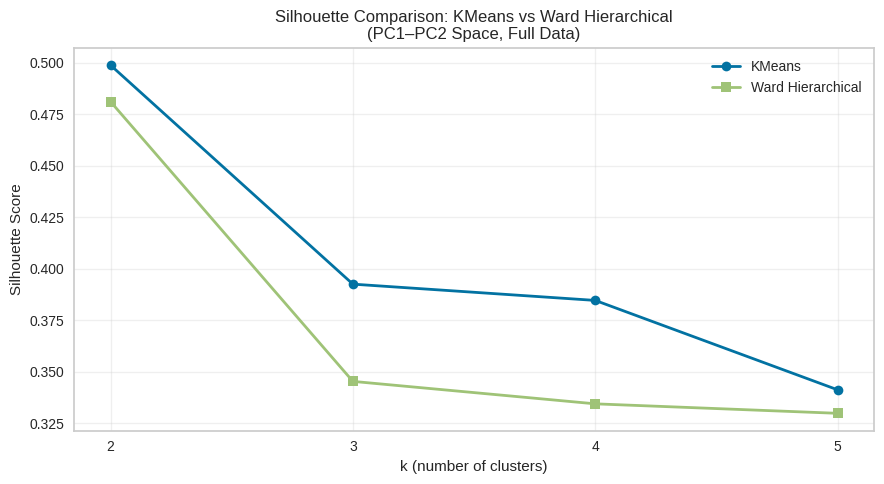

In [70]:
# Silhouette Comparison Plot

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(sil_df['k'], sil_df['KMeans_sil'], marker='o', label='KMeans', linewidth=2)
ax.plot(sil_df['k'], sil_df['Ward_sil'], marker='s', label='Ward Hierarchical', linewidth=2)
ax.set_xlabel('k (number of clusters)')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Comparison: KMeans vs Ward Hierarchical\n(PC1–PC2 Space, Full Data)')
ax.legend()
ax.set_xticks(range(2, 6))
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [71]:
# Cut at k=2 and Check Cluster Sizes
# Ward k=2
df_avg['hier_cluster'] = fcluster(Z, 2, criterion='maxclust').astype(str)
print("Ward Hierarchical (k=2):")
print(df_avg['hier_cluster'].value_counts())

# KMeans k=2
km = KMeans(n_clusters=2, random_state=42, n_init=25)
df_avg['kmeans_cluster'] = km.fit_predict(X_hier).astype(str)
print("\nKMeans (k=2):")
print(df_avg['kmeans_cluster'].value_counts())

Ward Hierarchical (k=2):
hier_cluster
2    2465
1     679
Name: count, dtype: int64

KMeans (k=2):
kmeans_cluster
0    2476
1     668
Name: count, dtype: int64


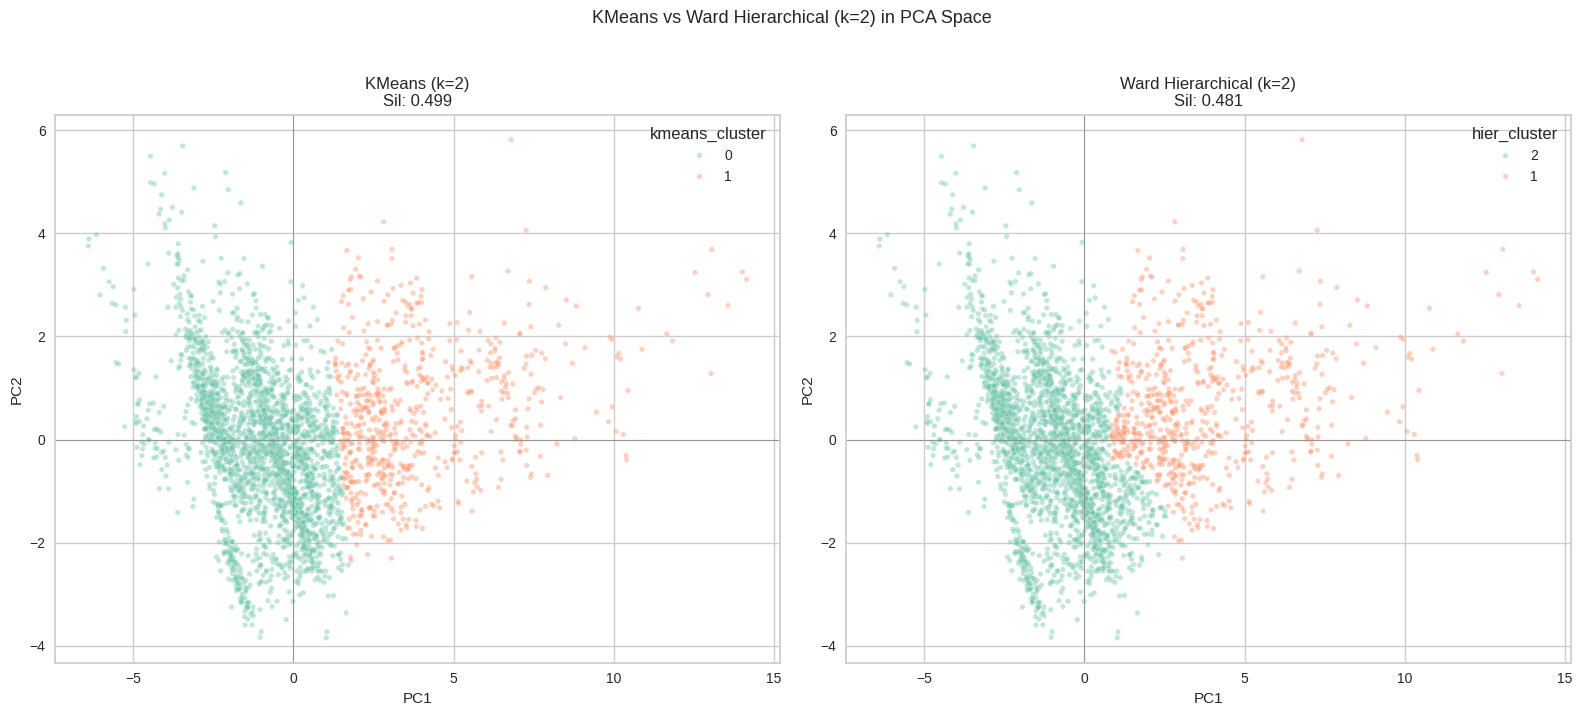

In [73]:
# Comparision KMeans vs Hierarchical in PCA Space

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# KMeans
sns.scatterplot(x=X_hier[:, 0], y=X_hier[:, 1],
                hue=df_avg['kmeans_cluster'], palette='Set2', alpha=0.4, s=15, ax=axes[0])
axes[0].set_title(f"KMeans (k=2)\nSil: {silhouette_score(X_hier, df_avg['kmeans_cluster'].astype(int)):.3f}")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].axhline(0, lw=0.5, c='gray')
axes[0].axvline(0, lw=0.5, c='gray')

# Hierarchical
sns.scatterplot(x=X_hier[:, 0], y=X_hier[:, 1],
                hue=df_avg['hier_cluster'], palette='Set2', alpha=0.4, s=15, ax=axes[1])
axes[1].set_title(f"Ward Hierarchical (k=2)\nSil: {silhouette_score(X_hier, df_avg['hier_cluster'].astype(int)):.3f}")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].axhline(0, lw=0.5, c='gray')
axes[1].axvline(0, lw=0.5, c='gray')

plt.suptitle("KMeans vs Ward Hierarchical (k=2) in PCA Space", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()



Smaller cluster size: 679
Top 5% extreme in smaller cluster: 134/158 (84.8%)
Top 1% extreme in smaller cluster: 32/32 (100.0%)


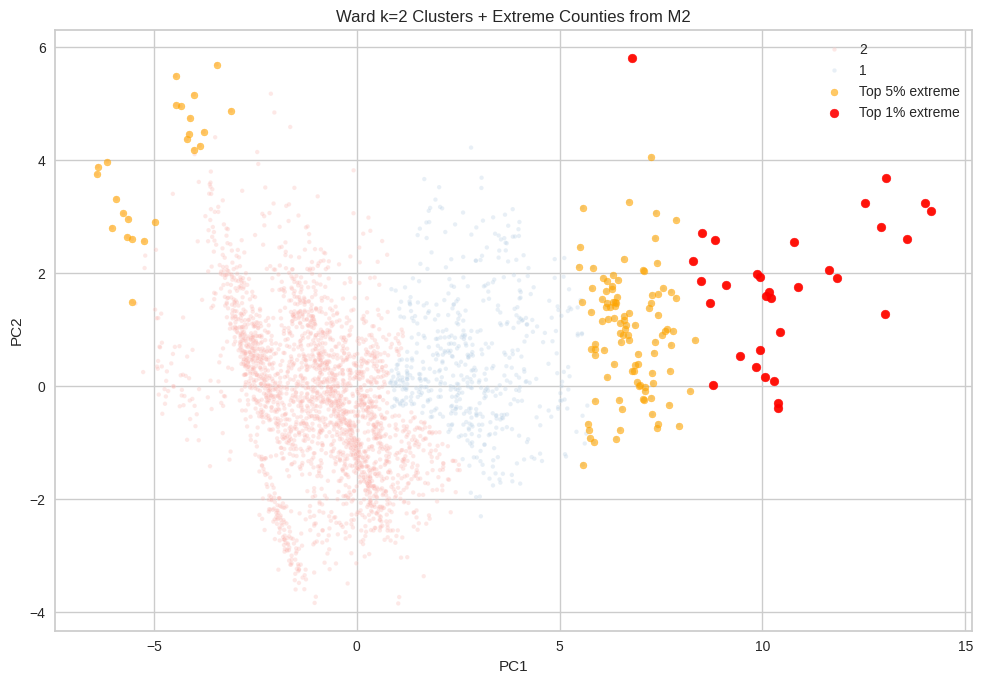

In [74]:
# Overlay Extreme Counties on Hierarchical Clusters
# Extremity flags from M2
dist_pc12 = np.sqrt(X_hier[:, 0]**2 + X_hier[:, 1]**2)
thr_95 = np.percentile(dist_pc12, 95)
thr_99 = np.percentile(dist_pc12, 99)
df_avg['extreme_5pct'] = dist_pc12 >= thr_95
df_avg['extreme_1pct'] = dist_pc12 >= thr_99

# What fraction of extreme counties land in the smaller cluster?
sizes = df_avg['hier_cluster'].value_counts()
small_cluster = sizes.idxmin()
in_small = df_avg['hier_cluster'] == small_cluster

overlap_5 = (df_avg['extreme_5pct'] & in_small).sum()
overlap_1 = (df_avg['extreme_1pct'] & in_small).sum()

print(f"Smaller cluster size: {sizes[small_cluster]}")
print(f"Top 5% extreme in smaller cluster: {overlap_5}/{df_avg['extreme_5pct'].sum()} ({overlap_5/df_avg['extreme_5pct'].sum()*100:.1f}%)")
print(f"Top 1% extreme in smaller cluster: {overlap_1}/{df_avg['extreme_1pct'].sum()} ({overlap_1/df_avg['extreme_1pct'].sum()*100:.1f}%)")

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_hier[:, 0], y=X_hier[:, 1],
                hue=df_avg['hier_cluster'], palette='Pastel1', alpha=0.3, s=10)
plt.scatter(X_hier[df_avg['extreme_5pct'].values, 0],
            X_hier[df_avg['extreme_5pct'].values, 1],
            c='orange', alpha=0.6, s=25, label='Top 5% extreme')
plt.scatter(X_hier[df_avg['extreme_1pct'].values, 0],
            X_hier[df_avg['extreme_1pct'].values, 1],
            c='red', alpha=0.9, s=40, label='Top 1% extreme')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Ward k=2 Clusters + Extreme Counties from M2")
plt.legend()
plt.tight_layout()
plt.show()


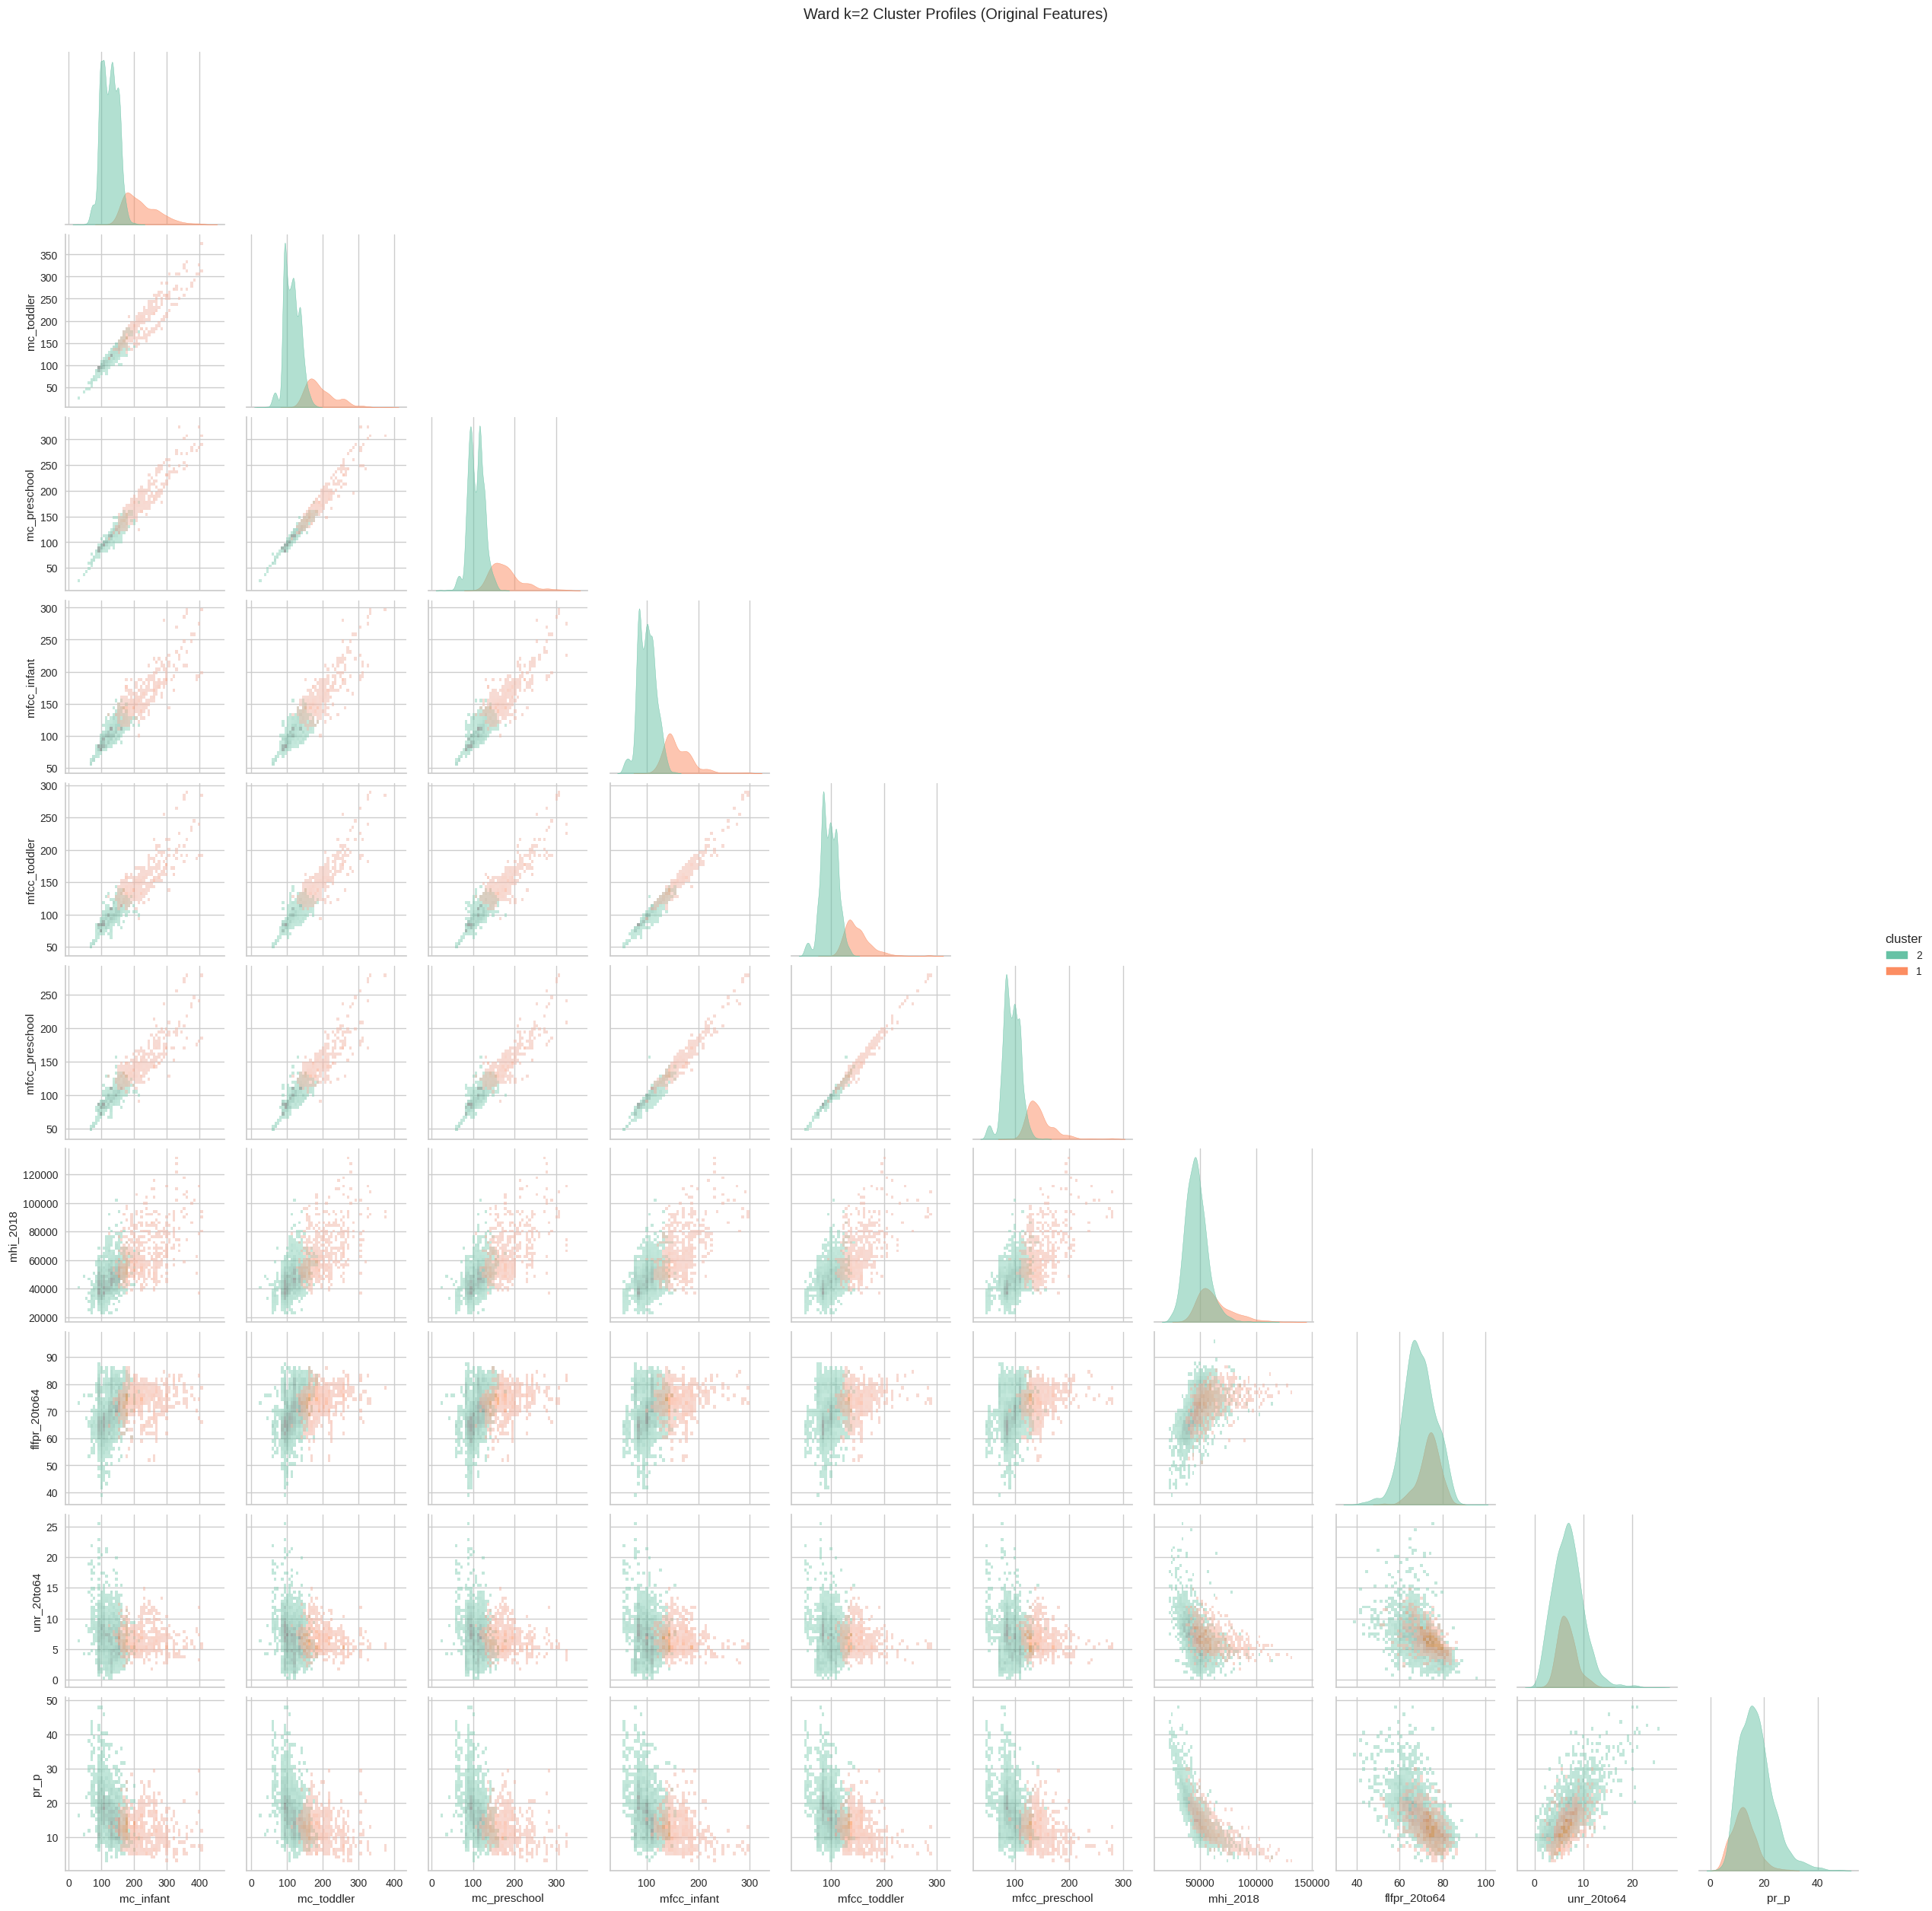

In [75]:
# Cluster Profiling: Pairplot
dprofile_df = df_avg[feature_cols].copy()
profile_df['cluster'] = df_avg['hier_cluster']

sns.pairplot(profile_df, hue='cluster', kind='hist', diag_kind='kde',
             corner=True, palette='Set2',
             plot_kws={'alpha': 0.5},
             diag_kws={'alpha': 0.5})
plt.suptitle("Ward k=2 Cluster Profiles (Original Features)", y=1.01)
plt.show()


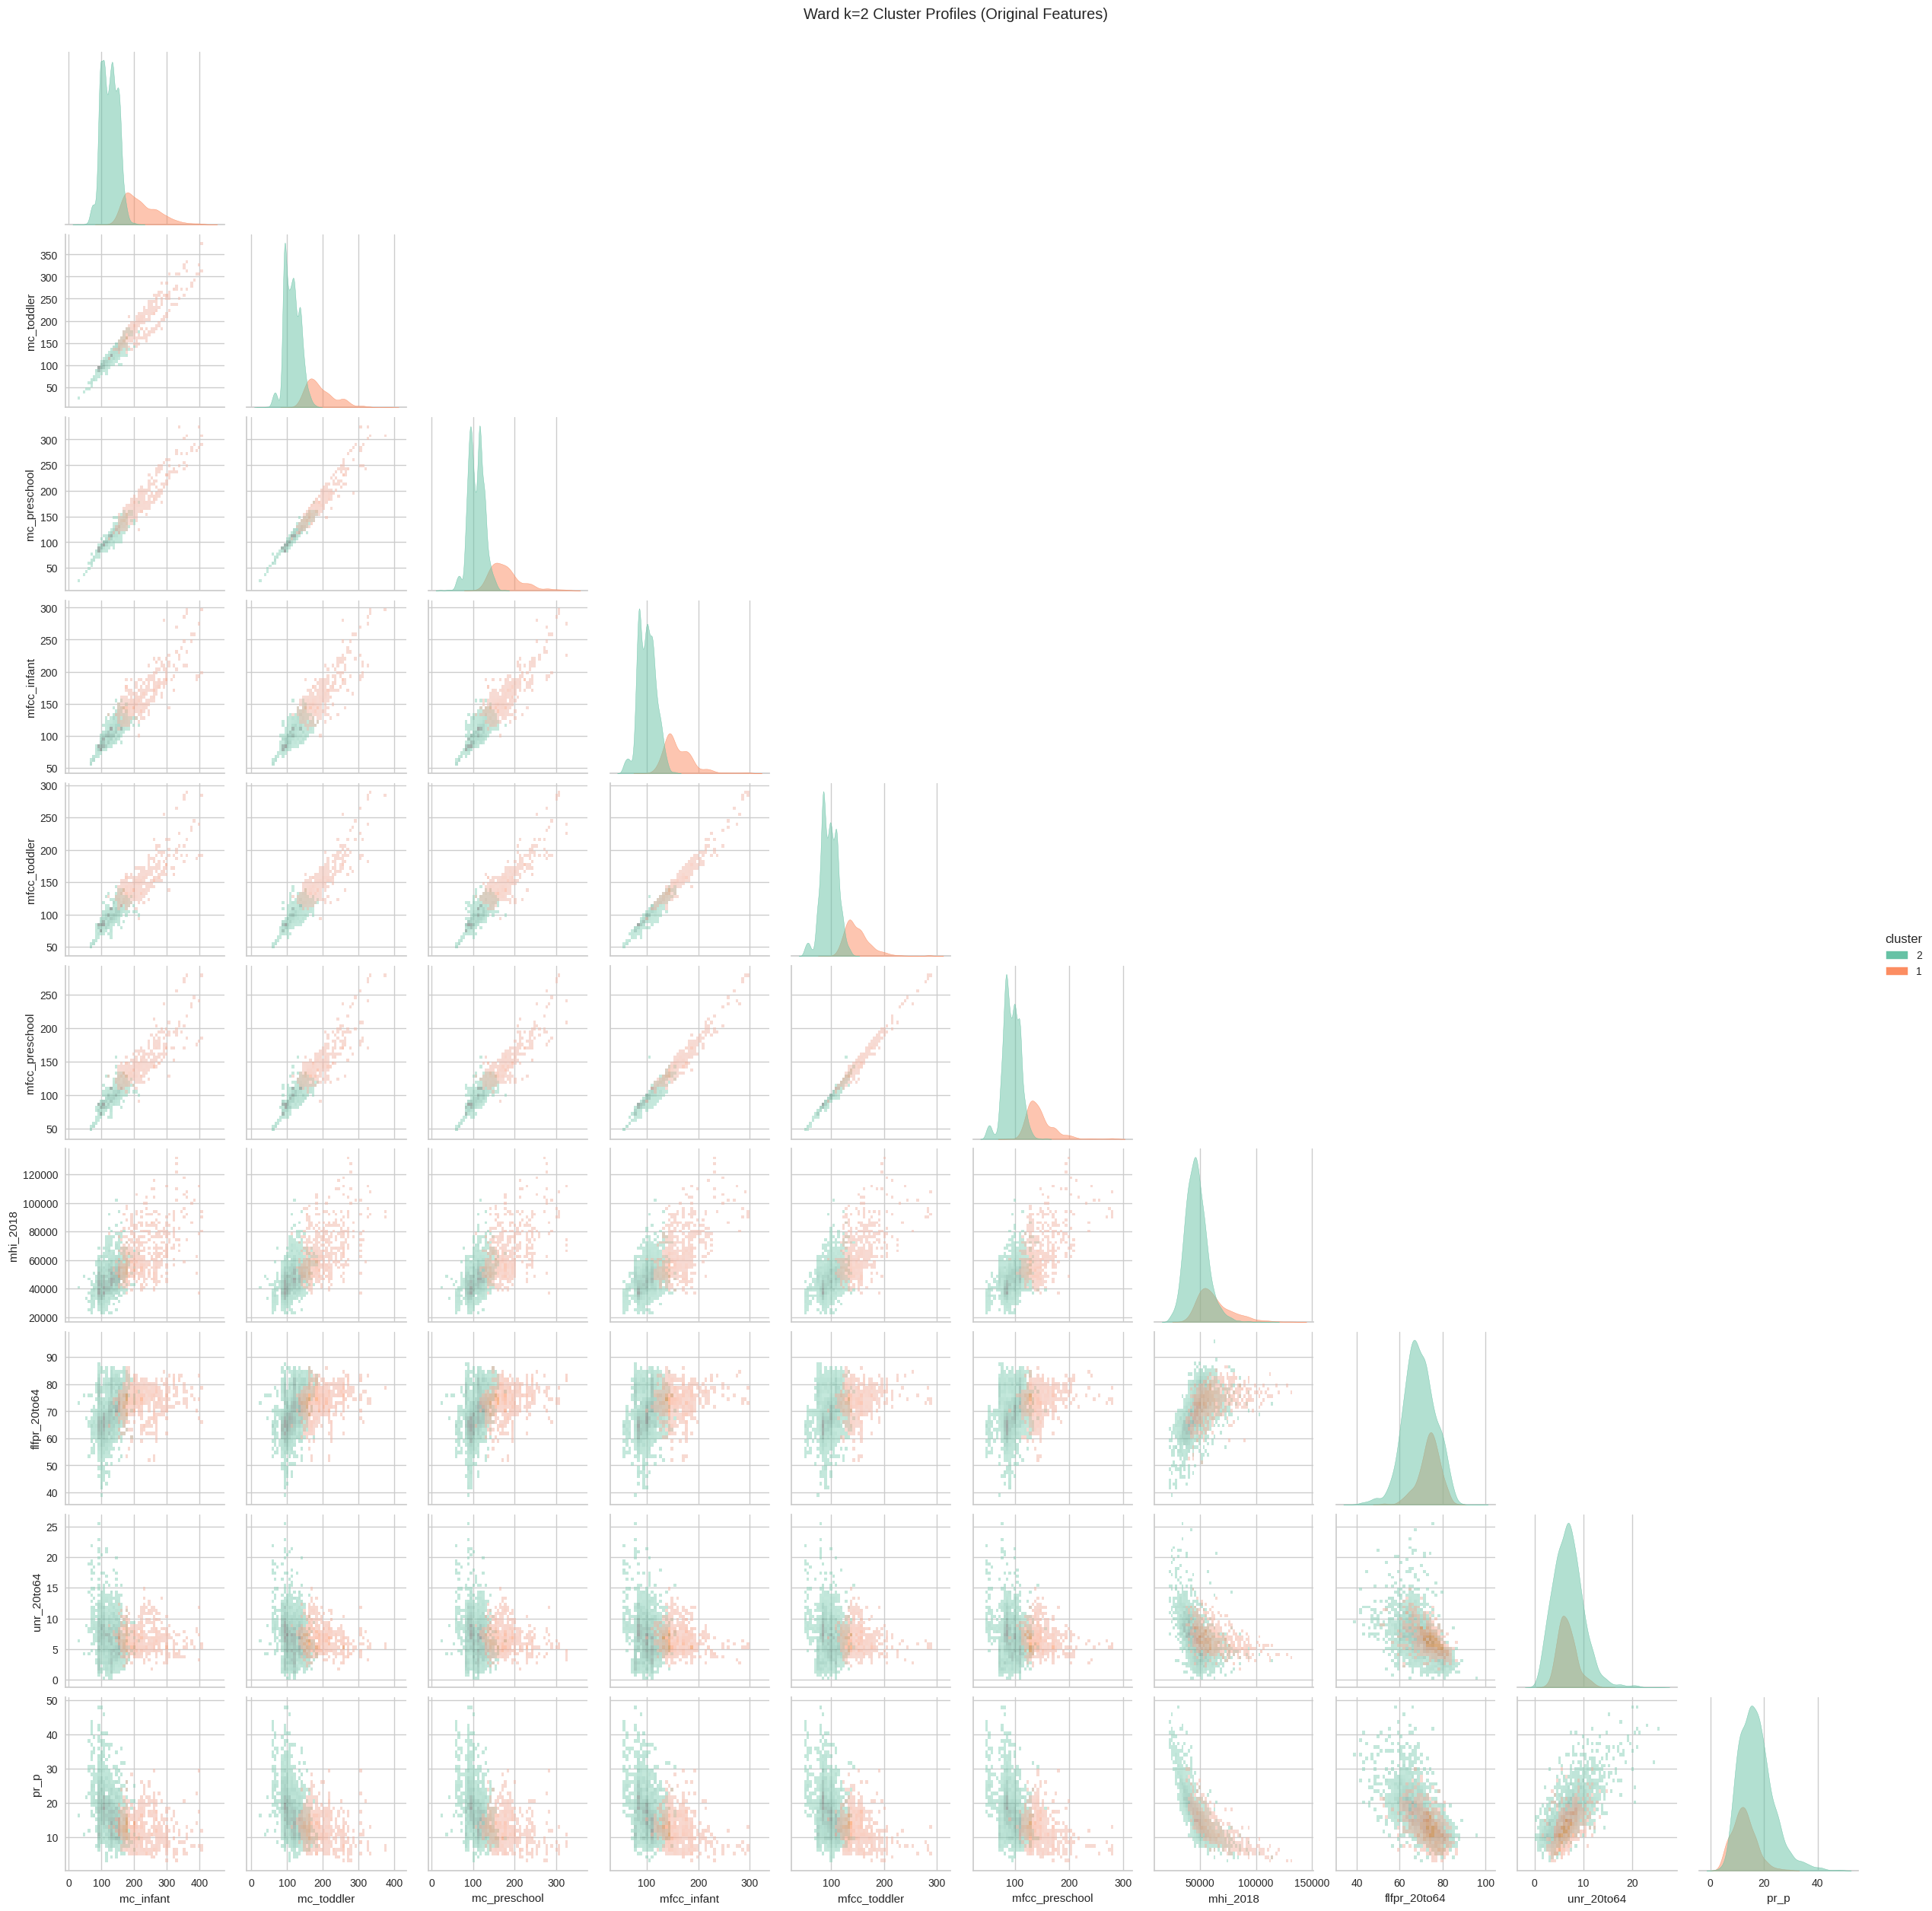

In [65]:
# Build profiling df with original-scale features + cluster labels
profile_df = df_avg[feature_cols].copy()
profile_df['cluster'] = df_avg['hier_cluster']

sns.pairplot(profile_df, hue='cluster', kind='hist', diag_kind='kde',
             corner=True, palette='Set2',
             plot_kws={'alpha': 0.5},
             diag_kws={'alpha': 0.5})
plt.suptitle("Ward k=2 Cluster Profiles (Original Features)", y=1.01)
plt.show()
